In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from functions import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
import pickle

In [2]:
# #预处理以得到所有的行动分类名称
# action_names = set()
# for filename in os.listdir(r"D:\新图像识别\jpegs_256"):
#     if filename.startswith("v_"):  # 仅处理视频文件
#         parts = filename.split("_")
#         if len(parts) >= 3:  # 确保文件名格式正确
#             action_names.add(parts[1])
# print(action_names)
# print(len(action_names))
# with open("UCF101actions.pkl", "wb") as f:
#     pickle.dump(action_names, f)  # 将列表写入文件
# with open("UCF101actions.pkl", "rb") as f:  # 注意模式为二进制读取`rb`:ml-citation{ref="3,7" data="citationList"}
#     data_test = pickle.load(f)
# print(data_test)
# print(len(data_test))

In [3]:
# set path
#data_path = "./jpegs_256/"    # define UCF-101 spatial data path
data_path = r"D:\新图像识别\jpegs_256"
action_name_path = r"D:\新图像识别\Conv3D\UCF101actions.pkl"  # load preprocessed action names
save_model_path = r"D:\新图像识别\Conv3D\Conv3D_ckpt"  # save Pytorch models

# 3D CNN parameters
fc_hidden1, fc_hidden2 = 256, 256
dropout = 0.0        # dropout probability

# training parameters
k = 101            # number of target category
epochs = 15
batch_size = 30
learning_rate = 1e-4
log_interval = 10
img_x, img_y = 256, 342  # resize video 2d frame size

# Select which frame to begin & end in videos
begin_frame, end_frame, skip_frame = 1, 29, 1

def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    model.train()

    losses = []
    scores = []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device).view(-1, )

        N_count += X.size(0)

        optimizer.zero_grad()
        output = model(X)  # output size = (batch, number of classes)

        loss = F.cross_entropy(output, y)
        losses.append(loss.item())

        # to compute accuracy
        y_pred = torch.max(output, 1)[1]  # y_pred != output
        step_score = accuracy_score(y.cpu().data.numpy(), y_pred.cpu().data.numpy())
        scores.append(step_score)         # computed on CPU

        loss.backward()
        optimizer.step()

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item(), 100 * step_score))

    return losses, scores


def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    model.eval()

    test_loss = 0
    all_y = []
    all_y_pred = []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )

            output = model(X)

            loss = F.cross_entropy(output, y, reduction='sum')
            test_loss += loss.item()                 # sum up batch loss
            y_pred = output.max(1, keepdim=True)[1]  # (y_pred != output) get the index of the max log-probability

            # collect all y and y_pred in all batches
            all_y.extend(y)
            all_y_pred.extend(y_pred)

    test_loss /= len(test_loader.dataset)

    # to compute accuracy
    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(len(all_y), test_loss, 100* test_score))

    # save Pytorch models of best record
    torch.save(model.state_dict(), os.path.join(save_model_path, '3dcnn_epoch{}.pth'.format(epoch + 1)))  # save spatial_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, '3dcnn_optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 1))

    return test_loss, test_score



In [8]:

# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# load UCF101 actions names
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}

# load UCF101 actions names
with open(action_name_path, 'rb') as f:
    action_names = pickle.load(f)   # load UCF101 actions names

#print(type(action_names)) 
action_list=list(action_names)
# convert labels -> category
le = LabelEncoder()
le.fit(action_list)#le存了101个目标动作的名字

# show how many classes there are
list(le.classes_)

# convert category -> 1-hot
action_category = le.transform(action_list).reshape(-1, 1)
enc = OneHotEncoder()#按顺序生成每个动作的独热向量
enc.fit(action_category)


# example
# y = ['HorseRace', 'YoYo', 'WalkingWithDog']
# y_onehot = labels2onehot(enc, le, y)
# print(y_onehot)
# y2 = onehot2labels(le, y_onehot)
# print(y2)


OneHotEncoder()

In [5]:

actions = []
fnames = os.listdir(data_path)

all_names = []
for f in fnames:
    loc1 = f.find('v_')
    loc2 = f.find('_g')
    actions.append(f[(loc1 + 2): loc2])

    all_names.append(f)

In [ ]:

# list all data files
all_X_list = all_names              # all video file names
all_y_list = labels2cat(le, actions)    # all video labels按顺序把每个jpeg的动作名称转换成数字
print(all_y_list)
# train, test split
train_list, test_list, train_label, test_label = train_test_split(all_X_list, all_y_list, test_size=0.25, random_state=42)
#随机选1/4用来测试，剩下的训练
# image transformation
transform = transforms.Compose([transforms.Resize([img_x, img_y]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])])
#compose函数是流水线，从前向后一个个执行，首先把图片标准化256*342，再转换成张量，最后标准化
selected_frames = np.arange(begin_frame, end_frame, skip_frame).tolist()

train_set, valid_set = Dataset_3DCNN(data_path, train_list, train_label, selected_frames, transform=transform), \
                       Dataset_3DCNN(data_path, test_list, test_label, selected_frames, transform=transform)
train_loader = data.DataLoader(train_set, **params)
valid_loader = data.DataLoader(valid_set, **params)

# create model
# CNN3D类定义在functions.py
cnn3d = CNN3D(t_dim=len(selected_frames), img_x=img_x, img_y=img_y,
              drop_p=dropout, fc_hidden1=fc_hidden1,  fc_hidden2=fc_hidden2, num_classes=k).to(device)


# Parallelize model to multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    cnn3d = nn.DataParallel(cnn3d)

optimizer = torch.optim.Adam(cnn3d.parameters(), lr=learning_rate)   # optimize all cnn parameters


# record training process
epoch_train_losses = []
epoch_train_scores = []
epoch_test_losses = []
epoch_test_scores = []

# start training
for epoch in range(epochs):
    # train, test model
    train_losses, train_scores = train(log_interval, cnn3d, device, train_loader, optimizer, epoch)
    epoch_test_loss, epoch_test_score = validation(cnn3d, device, optimizer, valid_loader)

    # save results
    epoch_train_losses.append(train_losses)
    epoch_train_scores.append(train_scores)
    epoch_test_losses.append(epoch_test_loss)
    epoch_test_scores.append(epoch_test_score)

    # save all train test results
    A = np.array(epoch_train_losses)
    B = np.array(epoch_train_scores)
    C = np.array(epoch_test_losses)
    D = np.array(epoch_test_scores)
    np.save('./3DCNN_epoch_training_losses.npy', A)
    np.save('./3DCNN_epoch_training_scores.npy', B)
    np.save('./3DCNN_epoch_test_loss.npy', C)
    np.save('./3DCNN_epoch_test_score.npy', D)


[  0   0   0 ... 100 100 100]


In [ ]:
epochs = 15

NameError: name 'epochs' is not defined

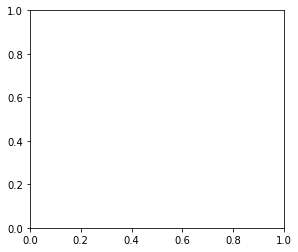

In [2]:
# plot
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(np.arange(1, epochs + 1), A[:, -1])  # train loss (on epoch end)
plt.plot(np.arange(1, epochs + 1), C)         #  test loss (on epoch end)
plt.title("model loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc="upper left")
# 2nd figure
plt.subplot(122)
plt.plot(np.arange(1, epochs + 1), B[:, -1])  # train accuracy (on epoch end)
plt.plot(np.arange(1, epochs + 1), D)         #  test accuracy (on epoch end)
# plt.plot(histories.losses_val)
plt.title("training scores")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc="upper left")
title = "./fig_UCF101_3DCNN.png"
plt.savefig(title, dpi=600)
# plt.close(fig)
plt.show()